In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from matplotlib import pyplot as plt

In [3]:
test_component = pd.read_csv("test_components_contexts.csv")
train_component = pd.read_csv("train_components_contexts.csv")
validation_component = pd.read_csv("validation_components_contexts.csv")

test_component.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


# Nouvelle section

In [4]:
# merge data
all_data = pd.concat([test_component, train_component, validation_component])

all_data.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


In [5]:
# remove all the null context
print(len(all_data))
all_data = all_data[all_data['context1'].notnull()]
print(len(all_data))
# reduce size of the dataset to reduce the time to process
# all_data = all_data.sample(n=int(len(all_data)/2)).sort_index()
# print(len(all_data))


32988
32748


In [6]:
# drop la classe Question car trop peu signifiante dans le dataset
all_data = all_data[all_data['Label'] != 'Question']

#get unique values of label (our class for the classification)
classes = all_data['Label'].unique()

In [7]:
# convert label to class
all_data.Label = pd.Categorical(all_data.Label)
all_data['label_code'] = all_data.Label.cat.codes


In [8]:
# for the experience we only keep column context1 and label code
all_data = all_data[['Text', 'label_code']]

Text(0.5, 1.0, 'Distribution of question text length in words')

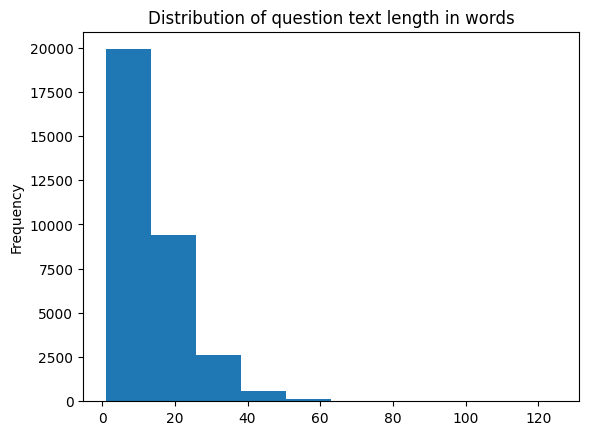

In [11]:
# repartition de la taille des text
all_data['Text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.title('Distribution of Text length')


In [14]:

# split into train, test and validation samples (80% , 10% and 10%)
train, validation, test = np.split(all_data.sample(frac=1, random_state=42), [int(.8*len(all_data)), int(.9*len(all_data))])
# train, validation, test = np.split(all_data.sample(frac=0.4, random_state=42), [int(.2*len(all_data)), int(.3*len(all_data))])

print(len(train))
print(len(validation))
print(len(test))

26148
3269
3269


### Source
https://www.intodeeplearning.com/bert-multiclass-text-classification/

In [15]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [16]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=130, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks


In [17]:
train_input_ids, train_att_masks = encode(train['Text'].values.tolist())
valid_input_ids, valid_att_masks = encode(validation['Text'].values.tolist())
test_input_ids, test_att_masks = encode(test['Text'].values.tolist())


In [18]:
import torch
train_y = torch.LongTensor(train['label_code'].values.tolist())
valid_y = torch.LongTensor(validation['label_code'].values.tolist())
test_y = torch.LongTensor(test['label_code'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()


(torch.Size([26148]), torch.Size([3269]), torch.Size([3269]))

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [20]:
from transformers import BertForSequenceClassification
N_labels = len(train.label_code.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [22]:
model = model.cuda()


In [23]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
# LEARNING_RATE = 2e-6
# LEARNING_RATE = 2e-6
LEARNING_RATE = 1e-3

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )


In [24]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(validation) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1635 [00:00<?, ?it/s]

Validation:   0%|          | 0/205 [00:00<?, ?it/s]

1635/1635 train loss: 0.7104820115486051 
205/205 val loss: 0.6970260762586826 
Epoch:  2


Training:   0%|          | 0/1635 [00:00<?, ?it/s]

Validation:   0%|          | 0/205 [00:00<?, ?it/s]

1635/1635 train loss: 0.6966104154193073 
205/205 val loss: 0.6973579962079118 
Epoch:  3


Training:   0%|          | 0/1635 [00:00<?, ?it/s]

Validation:   0%|          | 0/205 [00:00<?, ?it/s]

1635/1635 train loss: 0.6933832037704071 
205/205 val loss: 0.6925933041223665 
Epoch:  4


Training:   0%|          | 0/1635 [00:00<?, ?it/s]

Validation:   0%|          | 0/205 [00:00<?, ?it/s]

1635/1635 train loss: 0.6925135376621094 
205/205 val loss: 0.6916867642867855 
Epoch:  5


Training:   0%|          | 0/1635 [00:00<?, ?it/s]

Validation:   0%|          | 0/205 [00:00<?, ?it/s]

1635/1635 train loss: 0.6921498983642741 
205/205 val loss: 0.6915996260759307 


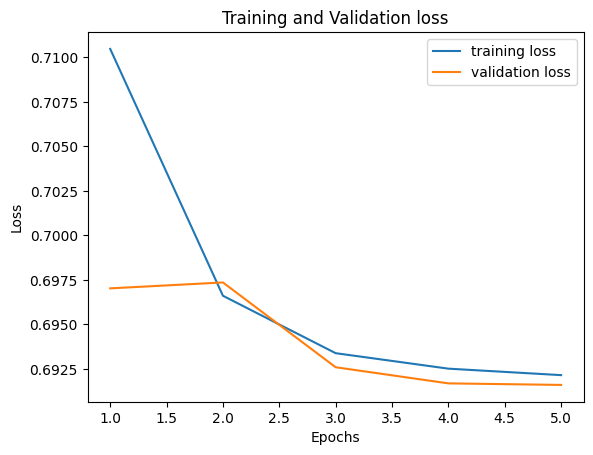

In [25]:
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


In [26]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, validation['label_code'].to_numpy(), target_names=classes))


classifiation report
              precision    recall  f1-score   support

     Premise       1.00      0.53      0.69      3269
       Claim       0.00      0.00      0.00         0

    accuracy                           0.53      3269
   macro avg       0.50      0.26      0.35      3269
weighted avg       1.00      0.53      0.69      3269



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()


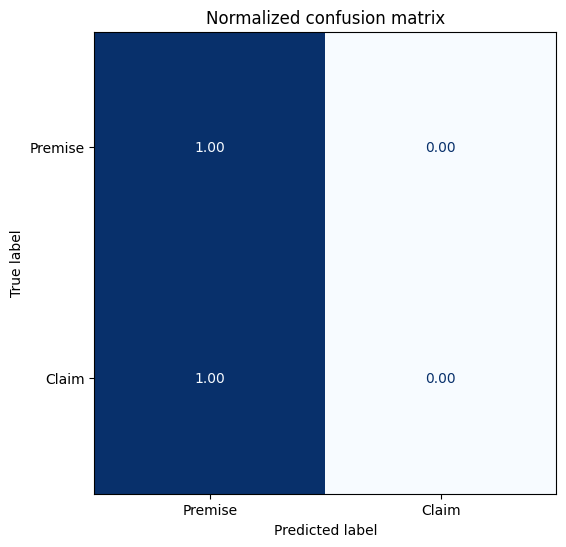

In [28]:
plot_confusion_matrix(valid_pred,validation['label_code'].to_numpy(),labels=classes)


In [29]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)


0it [00:00, ?it/s]

In [30]:
print('classifiation report')
print(classification_report(test_pred, test['label_code'].to_numpy(),target_names=classes))


classifiation report
              precision    recall  f1-score   support

     Premise       1.00      0.52      0.68      3269
       Claim       0.00      0.00      0.00         0

    accuracy                           0.52      3269
   macro avg       0.50      0.26      0.34      3269
weighted avg       1.00      0.52      0.68      3269



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


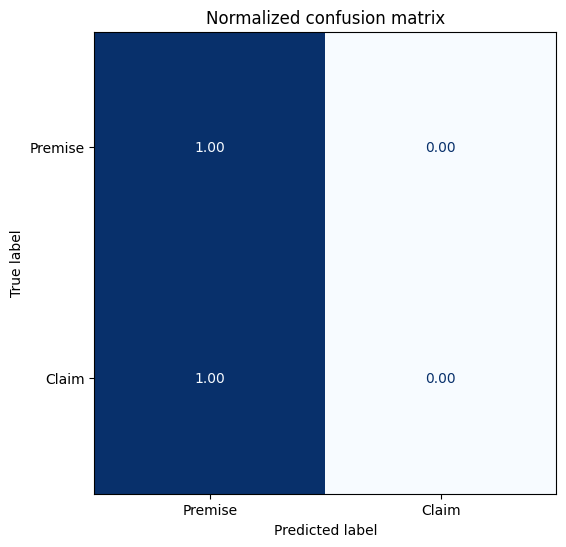

In [31]:
plot_confusion_matrix(test_pred,test['label_code'].to_numpy(),labels=classes)

In [32]:
# print misclassified component
test['pred'] = test_pred
test.reset_index(level=0)
print(test[test['label_code']!=test['pred']].shape)
test[test['label_code']!=test['pred']][['Text','label_code','pred']].head(10)

(1577, 3)


,Text,label_code,pred
8856,Americans had seen jobs being shipped overseas,1,0
5481,I'm from a big farm state,1,0
2765,We've talked to them about human rights,1,0
12279,It's not doing the job though,1,0
218,Laos is moving in that direction,1,0
4177,Maybe we need to do a better job in mental cli...,1,0
3877,But we get the job done,1,0
13634,Anybody can have deductions up to that amount,1,0
11840,It is those years of experience on an executiv...,1,0
725,whether it will move in the direction of freed...,1,0


In [40]:
print(len(train[train['label_code'] == 1]))
print(len(test[test['label_code'] == 1]))
print(len(validation[validation['label_code'] == 1]))

print(len(train[train['label_code'] == 0]))
print(len(test[test['label_code'] == 0]))
print(len(validation[validation['label_code'] == 0]))

12464
1577
1537
13684
1692
1732
